## Amazon Timestream With SageMaker
This is a notebook where we try to estimate the values of the sensors in out Timestream database with the N-BEATS-algorithm implemented by [darts](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html?highlight=nbeats#darts.models.forecasting.nbeats.NBEATSModel) python package

In [54]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
import timestreamquery as timestream
from IPython import display
import pandas as pd
import boto3
import botocore
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.models import NBEATSModel, TFTModel
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import holidays_timeseries
# import sagemaker
import sys
import seaborn as sns
import numpy as np
import holidays
import datetime as dt

In [3]:
#################################################
##### Timestream Configurations.  ###############
#################################################
ENDPOINT = "eu-west-1" # <--- specify the region service endpoint
PROFILE = "mose-timestream" # <--- specify the AWS credentials profile
DB_NAME = "SensorData" # <--- specify the database created in Amazon Timestream
TABLE_NAME = "particleTest" # <--- specify the table created in Amazon Timestream

client = timestream.createQueryClient(ENDPOINT, profile=PROFILE)

#################################################
##### SageMaker Configurations. #################
#################################################

eu-west-1


## Logical view of data ##
```sql
DESCRIBE <db_name>.<table_name>
```

In [4]:
query_describe = """
DESCRIBE {}.{}
""".format(DB_NAME, TABLE_NAME)

describe_table = timestream.executeQueryAndReturnAsDataframe(client, query_describe, True)

display.display(describe_table)

QueryId: AEDQCANHRYBERSFWGV72F2XAFD6346JJRHREG7NLZSZLD5JEIWJCIR5MCRHUGGI
2022-10-11 10:42:02. QueryId: AEDQCANHRYBERSFWGV72F2XAFD6346JJRHREG7NLZSZLD5JEIWJCIR5MCRHUGGI Time: 1.911. First result: 1.91. Time to read results: 0.0.


,Column,Type,Timestream attribute type
0,tagId,varchar,DIMENSION
1,gateway_id,varchar,DIMENSION
2,measure_name,varchar,MEASURE_NAME
3,time,timestamp,TIMESTAMP
4,temperature,double,MULTI
5,humidity,double,MULTI
6,mc_2_5,bigint,MULTI
7,mc_10_0,bigint,MULTI
8,mc_4_0,bigint,MULTI
9,nc_10_0,bigint,MULTI


In [5]:
sensors = describe_table[describe_table["Timestream attribute type"] == "MULTI"]["Column"]
columns_to_extract = ", ".join([f"ROUND(AVG({sensor_name}), 2) as {sensor_name}_" for sensor_name in sensors])


In [17]:
query_get_all_data_last_30_days = f"""
SELECT BIN(time, 1h) as time_, {columns_to_extract}
FROM {DB_NAME}.{TABLE_NAME}
WHERE time > ago(30d)
GROUP BY BIN(time, 1h)
ORDER BY BIN(time, 1h)
"""

df = timestream.executeQueryAndReturnAsDataframe(client, query_get_all_data_last_30_days, True)
display.display(df)

QueryId: AEDQCANHRYB45COGBZSC2AIQ4TZER6DIRFMNDJQESM7AANTQTT3LHPWCMMYSRUI
2022-10-11 10:43:42. QueryId: AEDQCANHRYB45COGBZSC2AIQ4TZER6DIRFMNDJQESM7AANTQTT3LHPWCMMYSRUI Time: 3.029. First result: 3.029. Time to read results: 0.0.


,time_,temperature_,humidity_,mc_2_5_,mc_10_0_,mc_4_0_,nc_10_0_,mc_1_0_,nc_0_5_,nc_2_5_,nc_1_0_,nc_4_0_,typical_particle_size_
0,2022-09-16 14:00:00.000000000,11.90,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-16 15:00:00.000000000,11.77,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-09-16 16:00:00.000000000,11.88,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-09-16 17:00:00.000000000,11.83,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-09-16 18:00:00.000000000,11.74,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,2022-10-11 06:00:00.000000000,6.27,99.0,1.83,3.08,2.58,6.25,1.00,2.75,6.08,5.17,6.25,1049.83
593,2022-10-11 07:00:00.000000000,6.48,99.0,1.75,3.00,2.58,6.33,1.08,3.17,6.17,5.17,6.33,900.75
594,2022-10-11 08:00:00.000000000,6.71,99.0,2.42,3.50,3.33,8.75,1.33,4.83,8.75,7.50,8.75,776.17
595,2022-10-11 09:00:00.000000000,7.44,99.0,2.75,4.58,3.83,9.67,1.42,4.75,9.50,7.92,9.67,950.83


# Set up N-BEATS model and train the model

In [18]:
df.index = pd.to_datetime(df.time_)
df.index = df.index.tz_localize(None)
series = fill_missing_values(
    TimeSeries.from_dataframe(df, value_cols=[sensor_name + "_" for sensor_name in sensors], fill_missing_dates=True))

2022-10-11 12:43:45 darts.timeseries WARNING: Number of components is larger than 10 (12). Plotting only the first 10 components.


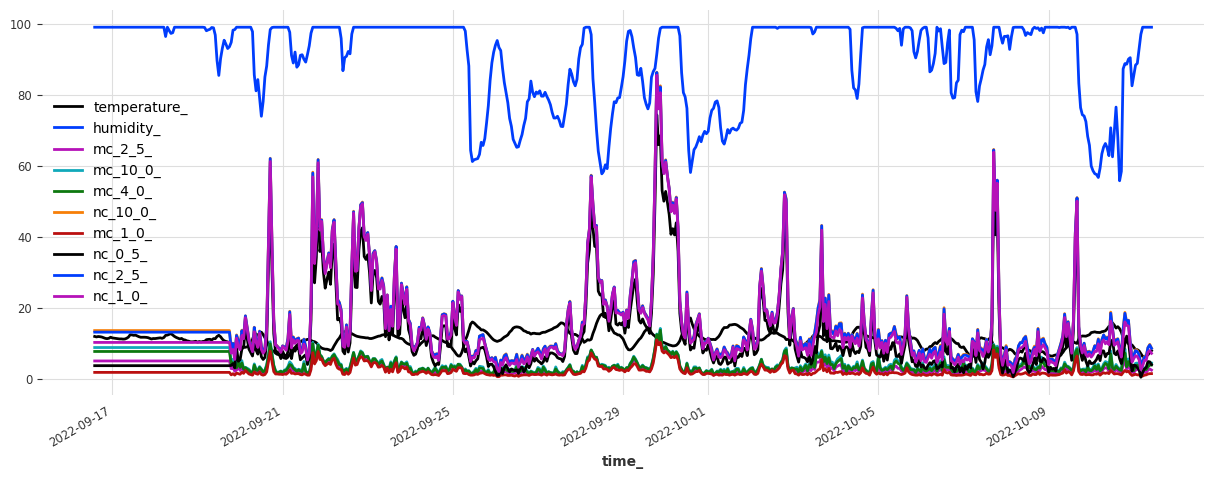

In [19]:
series.plot()

In [30]:
def is_workday(idx):
    print(idx.year)
    date = dt.date(idx.year, idx.month, idx.day)
    return not (date in holidays.NO() or date.weekday() > 4)

In [47]:
def workday_series(datetime_index: pd.DatetimeIndex):
    """Checks if an datetimeIndex is a Norwegian workday 

    :param date: a datetimeIndex object to check 
    :return: TimeSeries of workdays
    """    
    holidays_series = holidays_timeseries(datetime_index, country_code="NO").pd_series() == 1.
    weekdays = datetime_index.to_series().dt.dayofweek <= 4
    df = pd.DataFrame({"weekday": weekdays, "holidays": holidays_series})
    df = df.apply(lambda row: row['weekday'] & ~row['holidays'], axis=1)
    return TimeSeries.from_series(df)

In [48]:
import os
LOAD = False         # True = load previously saved model from disk?  False = (re)train the model
SAVE = "\_NBEATS_model_00.pth.tar"   # file name to save the model under

EPOCHS = 100
INLEN = 168         # input size, one week
BLOCKS = 64         
LWIDTH = 32
BATCH = 32          # batch size
LEARN = 1e-3        # learning rate
VALWAIT = 1         # epochs to wait before evaluating the loss on the test/validation set
N_FC = 24           # output size, one day

RAND = 42           # random seed
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = -1         # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]

SPLIT = 0.9         # train/test %

FIGSIZE = (9, 6)


qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

mpath = os.path.abspath(os.getcwd()) + SAVE

In [49]:
add_encoders = {
    'datetime_attribute': {'past': ['hour'], 'future': ['hour']},
    'custom': {'past': [lambda idx: workday_series(idx)], 'future': [lambda idx: workday_series(idx)]},
    'transformer': Scaler()
}

In [52]:
train, val = series[:-24], series[-24:]
model_nbeats = NBEATSModel(    input_chunk_length=INLEN,
                        output_chunk_length=N_FC, 
                        num_stacks=BLOCKS,
                        layer_widths=LWIDTH,
                        batch_size=BATCH,
                        n_epochs=EPOCHS,
                        nr_epochs_val_period=VALWAIT, 
                        likelihood=QuantileRegression(QUANTILES), 
                        optimizer_kwargs={"lr": LEARN}, 
                        model_name="NBEATS_EnergyES",
                        log_tensorboard=True,
                        generic_architecture=True, 
                        random_state=RAND,
                        force_reset=True,
                        save_checkpoints=True,
                        add_encoders=add_encoders
                    )

In [ ]:
model_tft = TFTModel(
    
)

In [53]:
if LOAD:
    print("have loaded a previously saved model from disk:" + mpath)
    model_nbeats = NBEATSModel.load_model(mpath)                            # load previously model from disk 
else:
    model_nbeats.fit(  series=train, 
                # val_series=val,
                verbose=True)
    print("have saved the model after training:", mpath)
    model_nbeats.save(mpath)

c:\Users\haako\Anaconda3\envs\tdt4290\lib\site-packages\darts\timeseries.py:4079: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(
c:\Users\haako\Anaconda3\envs\tdt4290\lib\site-packages\darts\timeseries.py:4079: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(
c:\Users\haako\Anaconda3\envs\tdt4290\lib\site-packages\darts\timeseries.py:928: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array(values) if not isinstance(values, np.ndarray) else values


ValueError: different number of dimensions on data and dims: 32 vs 3

In [16]:
prediction_nbeats = model_nbeats.predict(n=24, num_samples=1000, series=train[-480:])

2022-10-11 12:42:38 main_logger ERROR: ValueError: All input series must have length >= `input_chunk_length` (480).


ValueError: All input series must have length >= `input_chunk_length` (480).

2022-10-11 10:29:44 darts.timeseries WARNING: Number of components is larger than 10 (12). Plotting only the first 10 components.


Index(['temperature_', 'humidity_', 'mc_2_5_', 'mc_10_0_', 'mc_4_0_',
       'nc_10_0_', 'mc_1_0_', 'nc_0_5_', 'nc_2_5_', 'nc_1_0_', 'nc_4_0_',
       'typical_particle_size_'],
      dtype='object', name='component')


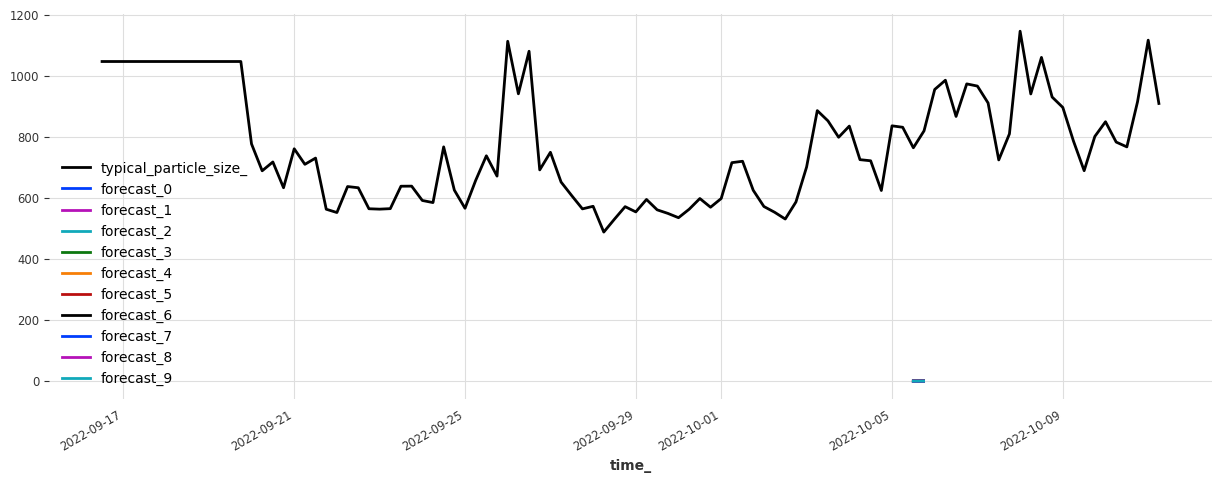

In [ ]:
print(series.columns)
series["typical_particle_size_"].plot()
prediction_nbeats.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)